## Import data from Kaggle

We are using the "US Used cars dataset" from "https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset/data"

In [1]:
import os 
import kaggle

In [2]:
kaggleDataset = "ananaymital/us-used-cars-dataset"
datasetPath = os.path.join("dataset", "Used Cars")

In [3]:
kaggle.api.dataset_download_files(kaggleDataset, datasetPath, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset


In [4]:
import pandas as pd 

def loadCarData(datasetPath=datasetPath):
    csvPath = os.path.join(datasetPath, "used_cars_data.csv")
    return pd.read_csv(csvPath, nrows=200000, low_memory=False)

c:\Users\maxim\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\maxim\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Examine quick info about the data structure

In [5]:
cars = loadCarData()
cars.head()

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
0,ZACNJABB5KPJ92081,35.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,Bayamon,NaN,NaN,...,A,9-Speed Automatic Overdrive,t83804,Latitude FWD,NaN,FWD,Front-Wheel Drive,101.2 in,79.6 in,2019
1,SALCJ2FX1LH858117,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020
2,JF1VA2M67G9829723,35.4 in,NaN,NaN,NaN,Sedan,NaN,Guaynabo,17.0,NaN,...,M,6-Speed Manual,t58994,Base,NaN,AWD,All-Wheel Drive,104.3 in,78.9 in,2016
3,SALRR2RV0L2433391,37.6 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,8-Speed Automatic Overdrive,t86074,V6 HSE AWD,NaN,AWD,All-Wheel Drive,115 in,87.4 in,2020
4,SALCJ2FXXLH862327,38.1 in,NaN,NaN,NaN,SUV / Crossover,NaN,San Juan,NaN,NaN,...,A,9-Speed Automatic Overdrive,t86759,S AWD,NaN,AWD,All-Wheel Drive,107.9 in,85.6 in,2020


In [6]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 66 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   vin                      200000 non-null  object 
 1   back_legroom             190542 non-null  object 
 2   bed                      1205 non-null    object 
 3   bed_height               20252 non-null   object 
 4   bed_length               20252 non-null   object 
 5   body_type                199210 non-null  object 
 6   cabin                    3372 non-null    object 
 7   city                     200000 non-null  object 
 8   city_fuel_economy        168272 non-null  float64
 9   combine_fuel_economy     0 non-null       float64
 10  daysonmarket             200000 non-null  int64  
 11  dealer_zip               200000 non-null  object 
 12  description              194926 non-null  object 
 13  engine_cylinders         194164 non-null  object 
 14  engi

In [7]:
cars.describe()

,city_fuel_economy,combine_fuel_economy,daysonmarket,engine_displacement,highway_fuel_economy,horsepower,is_certified,latitude,listing_id,longitude,mileage,owner_count,price,savings_amount,seller_rating,sp_id,vehicle_damage_category,year
count,168272.000000,0.0,200000.000000,189844.000000,168272.000000,189844.000000,0.0,200000.000000,2.000000e+05,200000.000000,191990.000000,106480.000000,2.000000e+05,200000.000000,198504.000000,199938.000000,0.0,200000.000000
mean,22.413081,NaN,79.169025,2845.121257,29.162546,244.913487,NaN,41.581147,2.751597e+08,-75.552247,31124.117876,1.453907,3.036053e+04,632.729185,4.184570,232826.663516,NaN,2017.552075
std,8.531514,NaN,114.032762,1214.559896,7.492993,87.053326,NaN,1.678323,9.343352e+06,6.364629,43103.621000,0.823083,2.274858e+04,1241.561023,0.539992,129413.952111,NaN,3.888968
min,7.000000,NaN,0.000000,700.000000,11.000000,70.000000,NaN,18.346700,6.370620e+07,-157.928000,0.000000,1.000000,2.990000e+02,0.000000,1.000000,41593.000000,NaN,1930.000000
25%,18.000000,NaN,14.000000,2000.000000,25.000000,175.000000,NaN,40.880800,2.743622e+08,-74.464400,7.000000,1.000000,1.829500e+04,0.000000,3.842105,65428.000000,NaN,2017.000000
50%,21.000000,NaN,36.000000,2500.000000,28.000000,241.000000,NaN,41.815700,2.784183e+08,-73.628400,14021.000000,1.000000,2.699900e+04,1.000000,4.285714,280659.000000,NaN,2019.000000
75%,25.000000,NaN,83.000000,3500.000000,32.000000,295.000000,NaN,42.501900,2.803457e+08,-71.642400,43776.000000,2.000000,3.818900e+04,899.000000,4.571429,333599.000000,NaN,2020.000000
max,127.000000,NaN,2624.000000,8400.000000,127.000000,903.000000,NaN,61.203100,2.816809e+08,-66.078500,785778.000000,15.000000,3.195000e+06,95484.000000,5.000000,440798.000000,NaN,2021.000000


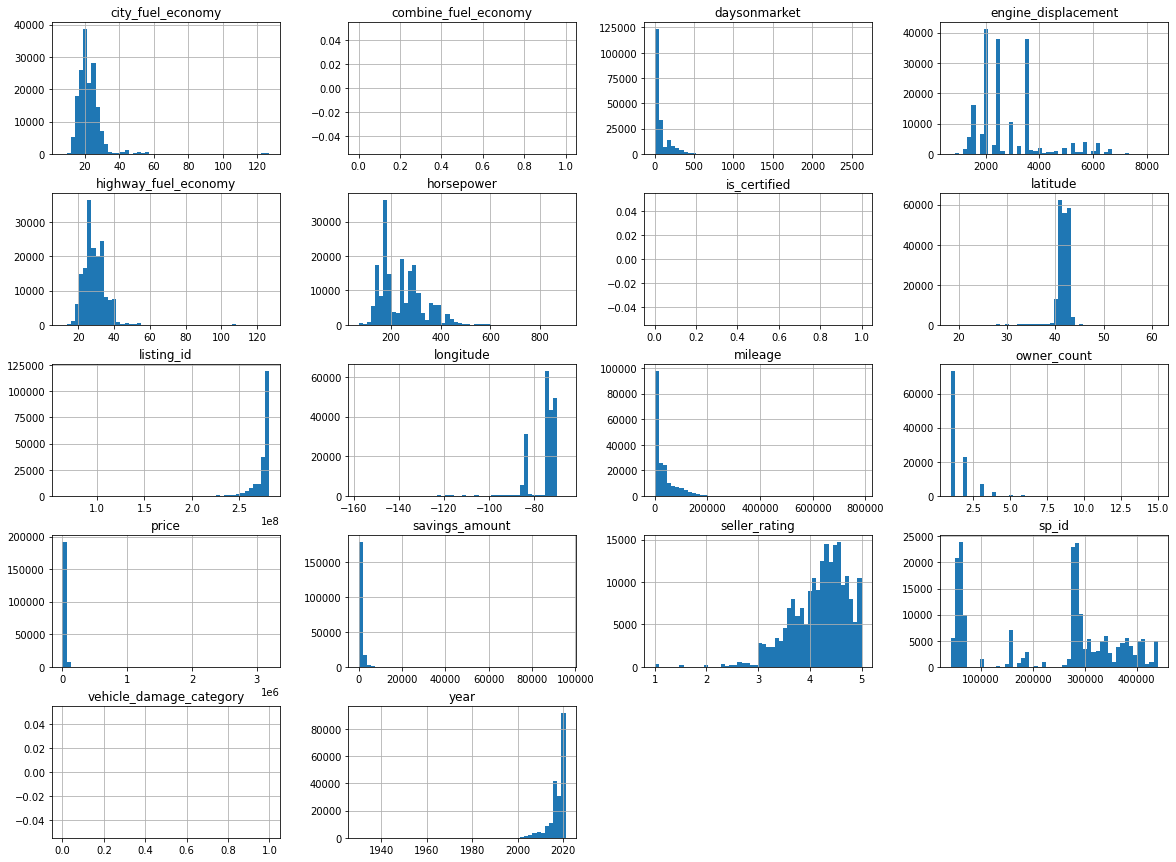

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

cars.hist(bins=50, figsize=(20,15))
plt.show()

Let's make a new column grouping "price", this will come in handy later to ensure our test set is not running into sampling bias. 

In [34]:
import numpy as np

cars["priceGroup"] = pd.cut(cars["price"],
                            bins=[0., 10000., 20000.,30000., 40000., 50000., np.inf],
                            labels=[1, 2, 3, 4, 5, 6])

<Axes: >

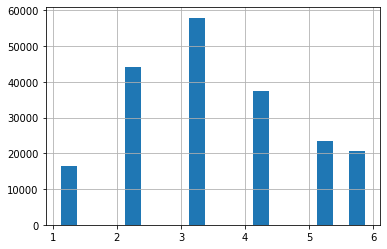

In [35]:
cars["priceGroup"].hist(rwidth=0.5)

In [37]:
cars["priceGroup"].value_counts() / len(cars)

priceGroup
3    0.289680
2    0.221030
4    0.186735
5    0.117580
6    0.103360
1    0.081615
Name: count, dtype: float64

## Set a side a test set, before changing anything on the data structure

In order to ensure that our test set stays consistent no matter how many times we rerun the program or update the dataset, we want to use a unique identifier to help us decide if the row should go into the test set or not. We can compute a hash for each row's unique identifier and if it is less than or equal to 20% of the maximum hash value, it will go into the test set. 

In [36]:
len(cars) - len(cars["listing_id"].unique()) # Making sure "listing_id" is unique

0

In [38]:
from zlib import crc32

def IDTest(ID, testRatio):
    return crc32(np.int64(ID)) & 0xffffffff < testRatio*2**32

def splitTrainTestByID(dataset,testRatio,ID):
    IDs = dataset[ID]
    testRows = IDs.apply(lambda ID_: IDTest(ID_, testRatio))
    return dataset.loc[~testRows], dataset.loc[testRows]

In [39]:
trainSet, testSet = splitTrainTestByID(cars, 0.2, "listing_id")

In [40]:
len(trainSet) / len(cars) # training set should be 80%

0.800635

In [41]:
len(testSet) / len(cars) # training set should be 20%

0.199365

Let's compare our test set's price group density to the overall price group density.

In [50]:
(testSet["priceGroup"].value_counts() / len(testSet)) - (cars["priceGroup"].value_counts() / len(cars))


priceGroup
3   -0.003246
2    0.000599
4    0.002416
5    0.001272
6    0.000294
1   -0.001335
Name: count, dtype: float64

The proportions of the price groups in our test set are nearly identical to the overall proportions, with the largest difference being 0.32% off. 
Therefore, it is not necessary to try and do stratified sampling. 

We can now be confident that our test set is a good representation of the overall dataset.